# Fine-tuning Classifier LLM


In [ ]:
# setup - load packages
import pandas as pd
from datasets import Dataset
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments, Trainer

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 13

cuda


In [ ]:
classifier_data = pd.read_csv("../data/classifier_data_A.csv")
# converting to huggingface dataset format
data = Dataset.from_pandas(classifier_data)
# splitting into train, test and validation sets
# party data
raw_dataset = data.shuffle(seed=seed)

# 70% train, 15% test, 15% validation data
split = raw_dataset.train_test_split(test_size=0.3, seed=seed)
train_data = split["train"]
text_and_val_data = split["test"]
split = text_and_val_data.train_test_split(test_size=0.5, seed=seed)
test_data = split["train"]
val_data = split["test"]

print(f"Training samples party: {len(train_data)}")
print(f"test samples party: {len(test_data)}")
print(f"Validation samples party: {len(val_data)}")



# data balancing??


In [33]:
# Load Model
model_name = "bert-base-german-cased"
num_labels = 6
max_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels= num_labels) # classification head with one linear layer and num_label outputs is added on top of model here.

print(f"Model parameters: {model.num_parameters():,}")

# quantized?!

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 109,085,958


In [ ]:
# define prediction function
# Define possible label names
label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']


def predicting_probs(model, speech):
    # Put model in eval mode
    model.eval()

    #  Tokenize input speeches
    tokens = tokenizer(speech, return_tensors="pt", truncation=False)["input_ids"][0]

    chunks = [tokens[i:i+max_length] for i in range(0, len(tokens), max_length)]

    all_probs = []
    i = 0
    for chunk in chunks:
        input_dict = {"input_ids": chunk.unsqueeze(0)}  # Add batch dimension
        # Add attention mask
        input_dict["attention_mask"] = (chunk != tokenizer.pad_token_id).unsqueeze(0)


        # Run model to predict baseline
        with torch.no_grad():
            outputs = model(**input_dict)
            logits = outputs.logits
            probabilities = F.softmax(logits, dim=1)
            all_probs.append(probabilities)
            i+=1
    # averaging probabilites over all probabilities in speech parts
    avg_probs = torch.mean(torch.cat(all_probs, dim=0), dim=0)
    print(i , avg_probs)

    return avg_probs


def predicting_probs_to_preds(model, speech):
    # get probabilites
    probabilities = predicting_probs(model, speech)
    # convert to predictions
    predictions_nr = torch.argmax(probabilities).item()
    predictions = label_names[predictions_nr]
    return predictions, probabilities



In [ ]:
# collect evaluation data
def evaluate_model(model, data):
    prediction_list = []
    probability_list = []
    true_label_list = []

    for i, row in enumerate(data):
        speech = row["speech_text"]
        pred, probs = predicting_probs_to_preds(model, speech)
        true_label = row["label"]
        prediction_list.append(pred)
        probability_list.append(probs)
        true_label_list.append(true_label)

        if (i+1) % 100 == 0:
            print(f"Processed samples {i+1} of {len(data)} samples.")

    return prediction_list, probability_list, true_label_list


# define function to display eval metrics
def get_metrics(true_labels, preds):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary







2 tensor([0.1638, 0.1763, 0.1356, 0.1829, 0.1976, 0.1439])
2 tensor([0.1672, 0.1794, 0.1407, 0.1917, 0.1851, 0.1359])
4 tensor([0.1416, 0.1736, 0.1349, 0.1676, 0.2092, 0.1731])
1 tensor([0.1766, 0.1864, 0.1316, 0.1716, 0.1737, 0.1600])
2 tensor([0.1714, 0.1774, 0.1366, 0.1686, 0.1937, 0.1523])
3 tensor([0.1592, 0.1944, 0.1489, 0.1750, 0.1919, 0.1307])
2 tensor([0.1515, 0.1829, 0.1564, 0.1505, 0.2032, 0.1556])
2 tensor([0.1481, 0.1805, 0.1386, 0.1783, 0.2015, 0.1530])
2 tensor([0.1567, 0.1791, 0.1503, 0.1910, 0.1812, 0.1417])
2 tensor([0.1830, 0.1787, 0.1432, 0.1813, 0.1825, 0.1314])
2 tensor([0.1488, 0.1712, 0.1350, 0.1757, 0.2253, 0.1440])
1 tensor([0.1555, 0.1856, 0.1391, 0.1738, 0.2094, 0.1366])
3 tensor([0.1610, 0.1727, 0.1535, 0.1758, 0.1915, 0.1454])
2 tensor([0.1663, 0.1954, 0.1321, 0.1807, 0.1814, 0.1442])
2 tensor([0.1624, 0.1677, 0.1351, 0.1836, 0.2178, 0.1335])
3 tensor([0.1588, 0.1871, 0.1419, 0.1819, 0.1936, 0.1367])
2 tensor([0.1479, 0.1596, 0.1451, 0.1900, 0.2028, 0.1545

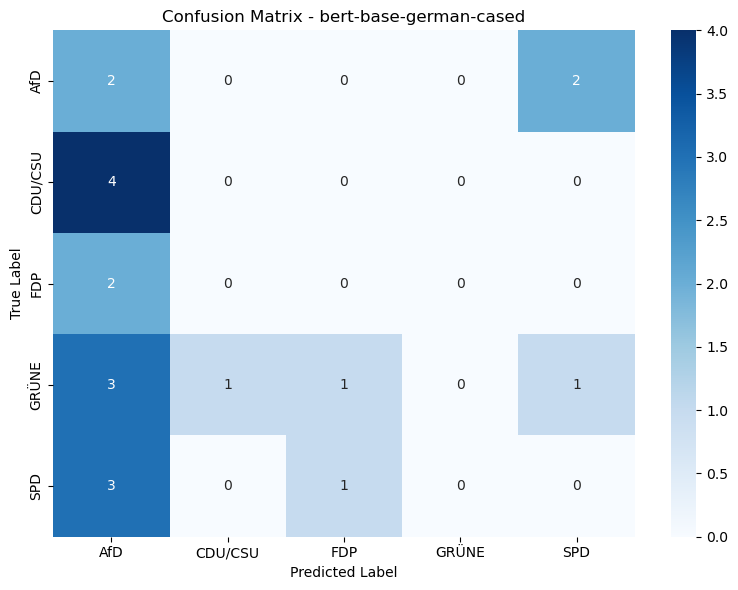

{'bert-base-german-cased': {'acc': 0.1,
  'bal_acc': 0.1,
  'precision': 0.02857142857142857,
  'recall': 0.1,
  'f1': 0.044444444444444446}}

In [ ]:
# Get zero-shot example performance
prediction_list, probability_list, true_label_list = evaluate_model(model, val_data)
print(probability_list)
get_metrics(true_label_list, prediction_list)

In [ ]:
preprocessed_data = preprocessed_data[:2000]

In [34]:
party_to_id = {party: i for i, party in enumerate(sorted(preprocessed_data['label'].unique()))}
preprocessed_data['label'] = preprocessed_data['label'].map(party_to_id)

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(preprocessed_data)

# Tokenize
def tokenize(batch):
    return tokenizer(batch['speech_text'], truncation=True, padding='max_length', max_length=max_length)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")  # required name
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

dataset = dataset.train_test_split(test_size=0.3)  # 90% train, 10% val
train_dataset = dataset['train']
val_and_test_dataset = dataset['test']
val_and_test_dataset = val_and_test_dataset.train_test_split(test_size=0.5)  # 90% train, 10% val
val_dataset = val_and_test_dataset['train']
test_dataset = val_and_test_dataset['test']

Map:   0%|          | 0/36117 [00:00<?, ? examples/s]

In [35]:
# fine-tunen
training_args = TrainingArguments(
    output_dir="./bert-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)


In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# train
trainer.train()


/tmp/ipython-input-1549188525.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.949800,0.873547,0.659468
2,0.672300,0.771991,0.706165
3,0.396900,0.857263,0.717977


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=9483, training_loss=0.7657745885884197, metrics={'train_runtime': 1706.159, 'train_samples_per_second': 44.452, 'train_steps_per_second': 5.558, 'total_flos': 1.9955848447973376e+16, 'train_loss': 0.7657745885884197, 'epoch': 3.0})

In [37]:
# validaten

trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.8572631478309631,
 'eval_accuracy': 0.7179771133259505,
 'eval_runtime': 35.9672,
 'eval_samples_per_second': 150.637,
 'eval_steps_per_second': 18.851,
 'epoch': 3.0}

In [ ]:
# compare 2 versions (erinnern!)



In [ ]:
# outcomes test data conf matrix, accuracy



In [ ]:
# save model for futher tests on LLM generated speeches



__________________________________________________________________________________

Old to save
__________________________________________________________________________________

In [ ]:
# Load Model
model_name = "bert-base-german-cased"
num_labels = 6
max_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels= num_labels) # classification head with one linear layer and num_label outputs is added on top of model here.

print(f"Model parameters: {model.num_parameters():,}")

# Put model in eval mode
model.eval()

# Define possible label names
label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']

#  Tokenize input speeches
inputs = tokenizer(val_data_subset["speech_text"], return_tensors="pt", padding=True, truncation=False) # padding pads all speeches to the same length and truncation cuts all speeches to 512 tokens

# Run model to predict basline
with torch.no_grad(): # turns of gradient tracking, since we are not training
    outputs = model(**inputs) # passes tokenized inputs into model, returns output dict
    logits = outputs.logits # output dict contains logits
    probabilities = F.softmax(logits, dim=1) # logits to probabilities
    predictions = torch.argmax(probabilities, dim=1) # probabilities to predictions (i.e. highest probability)

# 7. Print prediction examples
for i, pred in enumerate(predictions):
    print(f"Speech {i+1}: predicted party = {label_names[pred]}")
print(logits)

for i, probs in enumerate(probabilities):
    print(f"Speech {i+1} prediction:")
    for label, prob in zip(label_names, probs):
        print(f"  {label:7s}: {prob.item():.2%}")